# CS6700 : Programming Assignment - 2
Students:
- Janmenjaya Panda (ME20B087)
- Nishant Sahoo (ME20B122)

In [1]:
# Importing required libraries
import os
import gym
import csv
# from gym.wrappers import Monitor
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils as nn_utils
import random
import copy
import cv2
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
def seed_all(seed=None):
    if seed is None:
        seed = 87 + 122

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

seed_all()

## Parameters

In [3]:
class Args:
    def __init__(self):
        self.h1_dim = 128 # Hidden layer 1 dimension
        self.h2_dim = 128 # Hidden layer 2 dimension
        self.gamma = 0.99 # Discount factor (constant)

        self.lr = 1e-4 # Learning rate for policy network
        self.batch_size = 32 # Batch size for experience replay
        self.buffer_size = int(1e4) # Experience replay buffer size
        self.target_update_freq = 20 # Frequency of updating target network
        
        self.lr_theta = 1e-4 # Learning rate for policy network
        self.lr_w = 1e-4 # Learning rate for value network

        self.max_episodes = 1000
        self.max_steps = 500
        self.runs = 5
        self.epsilon0 = 1.0
        self.min_epsilon = 0.0001
        self.epsilon_decay = 0.98
        self.print_freq = 200

args = Args()

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dueling DQN

In [4]:
# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def __len__(self):
        return len(self.buffer)

In [5]:
# Dueling DQN
class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim, update_type=1, args=args):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, args.h1_dim)
        self.fc2 = nn.Linear(args.h1_dim, args.h2_dim)

        self.value = nn.Linear(args.h2_dim, 1)
        self.advantage = nn.Linear(args.h2_dim, action_dim)
        self.update_type = update_type
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu', mode='fan_in') # He initialization for ReLU
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        value = self.value(x)
        advantage = self.advantage(x)

        if self.update_type == 1:
            q = value + (advantage - advantage.mean(dim=-1, keepdim=True))
        elif self.update_type == 2:
            q = value + (advantage - advantage.max(dim=-1, keepdim=True)[0])
        else:
            raise NotImplementedError("Update type not implemented")

        return q


In [6]:
# Dueling DQN Agent
class DuelingDQNAgent:
    def __init__(self, state_dim, action_dim, update_type=1, args=args):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.update_type = update_type
        self.args = args
        self.q_net = DuelingDQN(state_dim, action_dim, update_type, self.args).to(device)
        self.target_net = copy.deepcopy(self.q_net)
        self.target_net.eval()
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.args.lr)
        self.loss_fn = nn.MSELoss()
        self.replay_buffer = ReplayBuffer(self.args.buffer_size)
        self.steps = 0

    def act(self, state, epsilon):
        if np.random.rand() < epsilon:
            return np.random.choice(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = self.q_net(state)
        return q_values.argmax().item()

    def update(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done) # Add to replay buffer
        if len(self.replay_buffer) < self.args.batch_size: # Wait until buffer is filled
            return 0

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.args.batch_size)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = self.q_net(states)
        next_q_values = self.target_net(next_states).detach()

        q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_value = next_q_values.max(dim=-1)[0]
        target = rewards + self.args.gamma * next_q_value * (1 - dones)

        loss = self.loss_fn(q_value, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step() # Update policy network

        self.steps += 1
        if self.steps % self.args.target_update_freq == 0:
            self.target_net.load_state_dict(self.q_net.state_dict()) # Update target network

        return loss.item()


## Monte-Carlo REINFORCE

In [7]:
# Policy Network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, args=args):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, args.h1_dim)
        self.fc2 = nn.Linear(args.h1_dim, args.h2_dim)
        self.fc3 = nn.Linear(args.h2_dim, action_dim)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu', mode='fan_in')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=-1)


In [8]:
# Value Network
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, args=args):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, args.h1_dim)
        self.fc2 = nn.Linear(args.h1_dim, args.h2_dim)
        self.fc3 = nn.Linear(args.h2_dim, 1)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu', mode='fan_in') # He initialization for ReLU
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [9]:
# Monte Carlo REINFORCE Agent
class MonteCarloREINFORCEAgent:
    def __init__(self, state_dim, action_dim, baseline=False, args=args):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.args = args
        self.policy_net = PolicyNetwork(state_dim, action_dim, self.args).to(device)
        self.value_net = ValueNetwork(state_dim, self.args).to(device)
        self.optimizer_theta = optim.Adam(self.policy_net.parameters(), lr=self.args.lr_theta)
        self.optimizer_w = optim.Adam(self.value_net.parameters(), lr=self.args.lr_w)
        self.baseline = baseline
        self.loss_fn = nn.MSELoss()
        self.steps = 0

    def act(self, state):
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            probs = self.policy_net(state)
            action = torch.distributions.Categorical(probs).sample()
        return action.item()
    
    def update(self, trajectory):
        states, actions, rewards = zip(*trajectory) # Unzip trajectory
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        
        returns = self._compute_returns(rewards)
        
        if self.baseline: # Subtract baseline from returns
            values = self.value_net(states).squeeze()
            loss_w = self.loss_fn(values, returns)
            returns = returns - values.detach()
            self.optimizer_w.zero_grad()
            loss_w.backward()
            self.optimizer_w.step() # Update value network

        log_probs = torch.log(self.policy_net(states))
        log_probs_actions = log_probs.gather(1, actions.unsqueeze(1)).squeeze()
        loss_theta = -torch.mean(log_probs_actions * returns)
        
        self.optimizer_theta.zero_grad()
        loss_theta.backward()
        self.optimizer_theta.step() # Update policy network
        
        self.steps += 1
        return loss_theta.item()
    
    def _compute_returns(self, rewards):
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + self.args.gamma * G
            returns.insert(0, G)
        return torch.FloatTensor(returns).to(device)
    

## Trainer

In [10]:
# Training for Dueling DQN and REINFORCE
class Trainer:
    def __init__(self, env_name, agent_type, update_type=None, baseline=False, args=args, save_results=True):
        self.env_name = env_name
        self.agent_type = agent_type
        self.update_type = update_type
        self.baseline = baseline
        self.env = gym.make(env_name)
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        self.args = args
        self.save_results = save_results

    def get_agent(self):
        if self.agent_type == "dueling_dqn":
            return DuelingDQNAgent(self.state_dim, self.action_dim, self.update_type, self.args)
        elif self.agent_type == "reinforce":
            return MonteCarloREINFORCEAgent(self.state_dim, self.action_dim, self.baseline, self.args)
        else:
            raise NotImplementedError("Agent not implemented")

    def train(self):
        rewards = np.zeros((self.args.runs, self.args.max_episodes))
        losses = np.zeros((self.args.runs, self.args.max_episodes))
        returns = np.zeros((self.args.runs, self.args.max_episodes))
        for run in tqdm(range(self.args.runs)):
            seed_all(seed=run)
            self.agent = self.get_agent()
            rewards[run], losses[run], returns[run] = self.train_single_run()
            clear_output(wait=True)
        self.rewards = rewards
        self.losses = losses
        self.returns = returns
        if self.save_results: 
            self.save() # Save the results
        return rewards, losses, returns

    def train_single_run(self):
        if self.agent_type == "dueling_dqn":
            return self.train_DuelingDQN()
        elif self.agent_type == "reinforce":
            return self.train_MC_REINFORCE()
        else:
            raise NotImplementedError("Agent not implemented")

    def train_DuelingDQN(self):
        rewards = []
        losses = []
        episodic_returns = []
        frames = []  # List to store frames
        for episode in (range(self.args.max_episodes)):
            state = self.env.reset()
            episode_reward = 0
            episodic_return = 0
            for step in range(self.args.max_steps):
                epsilon = max(self.args.min_epsilon, self.args.epsilon0 * self.args.epsilon_decay**self.agent.steps)
                action = self.agent.act(state, epsilon)
                next_state, reward, done, _ = self.env.step(action)
                loss = self.agent.update(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward
                episodic_return = self.args.gamma * episodic_return + reward
                if episode == self.args.max_episodes - 1:
                    frames.append(self.env.render(mode='rgb_array'))  # Record frames
                if done:
                    break
            rewards.append(episode_reward)
            losses.append(loss)
            episodic_returns.append(episodic_return)
            if episode % self.args.print_freq == 0:
                print("Episode: {}, Reward: {}".format(episode, episode_reward))
        self.env.close()
        self.save_simulation(frames, f"simulations/{self.env_name}_{self.agent_type}.mp4")
        return rewards, losses, episodic_returns

    def train_MC_REINFORCE(self):
        rewards = []
        losses = []
        episodic_returns = []
        frames = []  # List to store frames
        for episode in (range(self.args.max_episodes)):
            state = self.env.reset()
            episode_reward = 0
            episodic_return = 0
            trajectory = []
            for step in range(self.args.max_steps):
                action = self.agent.act(state)
                next_state, reward, done, _ = self.env.step(action)
                trajectory.append((state, action, reward))
                state = next_state
                episode_reward += reward
                episodic_return = self.args.gamma * episodic_return + reward
                if episode == self.args.max_episodes - 1:
                    frames.append(self.env.render(mode='rgb_array'))  # Record frames
                if done:
                    break
            rewards.append(episode_reward)
            loss = self.agent.update(trajectory)
            losses.append(loss)
            episodic_returns.append(episodic_return)
            if episode % self.args.print_freq == 0:
                print("Episode: {}, Reward: {}".format(episode, episode_reward))
        self.env.close()
        self.save_simulation(frames, f"simulations/{self.env_name}_{self.agent_type}.mp4")
        return rewards, losses, episodic_returns
    
    def save(self):
        if self.agent_type == "dueling_dqn":
            os.makedirs("results", exist_ok=True)
            np.save(f"results/{self.env_name}_{self.agent_type}_{self.update_type}_rewards.npy", self.rewards)
            np.save(f"results/{self.env_name}_{self.agent_type}_{self.update_type}_losses.npy", self.losses)
            np.save(f"results/{self.env_name}_{self.agent_type}_{self.update_type}_returns.npy", self.returns)
        elif self.agent_type == "reinforce":
            os.makedirs("results", exist_ok=True)
            np.save(f"results/{self.env_name}_{self.agent_type}_{self.baseline}_rewards.npy", self.rewards)
            np.save(f"results/{self.env_name}_{self.agent_type}_{self.baseline}_losses.npy", self.losses)
            np.save(f"results/{self.env_name}_{self.agent_type}_{self.baseline}_returns.npy", self.returns)
        else:
            raise NotImplementedError("Agent not implemented")

    @staticmethod
    def save_simulation(frames, filename):
        os.makedirs("simulations", exist_ok=True)
        height, width, _ = frames[0].shape
        video_writer = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))
        
        for frame in frames:
            video_writer.write(frame)
        video_writer.release()

In [11]:
def results_loader(env_name, agent_type, update_type=None, baseline=False):
    if agent_type == "dueling_dqn":
        rewards = np.load(f"results/{env_name}_{agent_type}_{update_type}_rewards.npy")
        losses = np.load(f"results/{env_name}_{agent_type}_{update_type}_losses.npy")
        returns = np.load(f"results/{env_name}_{agent_type}_{update_type}_returns.npy")
    elif agent_type == "reinforce":
        rewards = np.load(f"results/{env_name}_{agent_type}_{baseline}_rewards.npy")
        losses = np.load(f"results/{env_name}_{agent_type}_{baseline}_losses.npy")
        returns = np.load(f"results/{env_name}_{agent_type}_{baseline}_returns.npy")
    else:
        raise NotImplementedError("Agent not implemented")
    return rewards, losses, returns

## Plot

In [21]:
class Plot:
    def __init__(self, rewards1, rewards2, losses1, losses2, returns1, returns2, save_path=None):
        self.rewards1 = rewards1
        self.rewards2 = rewards2
        self.losses1 = losses1
        self.losses2 = losses2
        self.returns1 = returns1
        self.returns2 = returns2
        self.save_path = save_path
        if "dueling" in self.save_path:
            self.label1 = "Type 1"
            self.label2 = "Type 2"
        else:
            self.label1 = "w/o baseline"
            self.label2 = "w/ baseline"
        self.plot_all()

    def plot_all(self):
        self.plot_rewards()
        self.plot_losses()
        self.plot_returns()
        self.plot_running_rewards()
        self.plot_running_returns()

    def plot_rewards(self):
        plt.figure(figsize=(10, 6))
        # if save_path has dueling in the name, then label = Type 1 else w/o baseline
        plt.plot(self.rewards1.mean(axis=0), label=self.label1, color='blue')
        plt.fill_between(np.arange(self.rewards1.shape[1]), self.rewards1.mean(axis=0) - self.rewards1.std(axis=0),
                         self.rewards1.mean(axis=0) + self.rewards1.std(axis=0), alpha=0.2, color='blue')
        plt.plot(self.rewards2.mean(axis=0), label=self.label2, color='red')
        plt.fill_between(np.arange(self.rewards2.shape[1]), self.rewards2.mean(axis=0) - self.rewards2.std(axis=0),
                         self.rewards2.mean(axis=0) + self.rewards2.std(axis=0), alpha=0.2, color='red')
        plt.xlabel("Episodes", fontsize=18)
        plt.ylabel("Episodic Rewards", fontsize=18)
        # plt.title("Episodic Rewards vs Episodes", fontsize=18)
        plt.legend(loc="lower right", fontsize=16)
        if self.save_path:
            os.makedirs("plots", exist_ok=True)
            plt.savefig(self.save_path + "_rewards.pdf", format='pdf', bbox_inches='tight')
        plt.show()

    def plot_losses(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.losses1.mean(axis=0), label=self.label1, color='blue')
        plt.fill_between(np.arange(self.losses1.shape[1]), self.losses1.mean(axis=0) - self.losses1.std(axis=0),
                         self.losses1.mean(axis=0) + self.losses1.std(axis=0), alpha=0.2, color='blue')
        plt.plot(self.losses2.mean(axis=0), label=self.label2, color='red')
        plt.fill_between(np.arange(self.losses2.shape[1]), self.losses2.mean(axis=0) - self.losses2.std(axis=0),
                         self.losses2.mean(axis=0) + self.losses2.std(axis=0), alpha=0.2, color='red')
        plt.xlabel("Episodes", fontsize=18)
        plt.ylabel("Loss", fontsize=18)
        # plt.title("Loss vs Episodes", fontsize=18)
        plt.legend(loc="lower right", fontsize=16)
        if self.save_path:
            plt.savefig(self.save_path + "_losses.pdf", format='pdf', bbox_inches='tight')
        plt.show()

    def plot_returns(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.returns1.mean(axis=0), label=self.label1, color='blue')
        plt.fill_between(np.arange(self.returns1.shape[1]), self.returns1.mean(axis=0) - self.returns1.std(axis=0),
                         self.returns1.mean(axis=0) + self.returns1.std(axis=0), alpha=0.2, color='blue')
        plt.plot(self.returns2.mean(axis=0), label=self.label2, color='red')
        plt.fill_between(np.arange(self.returns2.shape[1]), self.returns2.mean(axis=0) - self.returns2.std(axis=0),
                         self.returns2.mean(axis=0) + self.returns2.std(axis=0), alpha=0.2, color='red')
        plt.xlabel("Episodes", fontsize=18)
        plt.ylabel("Episodic Returns", fontsize=18)
        # plt.title("Episodic Returns vs Episodes", fontsize=18)
        plt.legend(loc="lower right", fontsize=16)
        if self.save_path:
            plt.savefig(self.save_path + "_returns.pdf", format='pdf', bbox_inches='tight')
        plt.show()

    def plot_running_rewards(self):
        plt.figure(figsize=(10, 6))
        window = 10
        ma_rewards1 = self.moving_average(self.rewards1.mean(axis=0), window)
        ma_rewards2 = self.moving_average(self.rewards2.mean(axis=0), window)
        fill_std1 = self.moving_average(self.rewards1.std(axis=0), window)
        fill_std2 = self.moving_average(self.rewards2.std(axis=0), window)
        plt.plot(ma_rewards1, label=self.label1, color='blue')
        plt.fill_between(np.arange(len(ma_rewards1)), ma_rewards1 - fill_std1, ma_rewards1 + fill_std1, alpha=0.2, color='blue')
        plt.plot(ma_rewards2, label=self.label2, color='red')
        plt.fill_between(np.arange(len(ma_rewards2)), ma_rewards2 - fill_std2, ma_rewards2 + fill_std2, alpha=0.2, color='red')
        plt.xlabel("Episodes", fontsize=18)
        plt.ylabel("Episodic Rewards", fontsize=18)
        # plt.title("Episodic Rewards vs Episodes", fontsize=18)
        plt.legend(loc="lower right", fontsize=16)
        if self.save_path:
            plt.savefig(self.save_path + "_running_rewards.pdf", format='pdf', bbox_inches='tight')
        plt.show()

    def plot_running_returns(self):
        plt.figure(figsize=(10, 6))
        window = 10
        ma_returns1 = self.moving_average(self.returns1.mean(axis=0), window)
        ma_returns2 = self.moving_average(self.returns2.mean(axis=0), window)
        fill_std1 = self.moving_average(self.returns1.std(axis=0), window)
        fill_std2 = self.moving_average(self.returns2.std(axis=0), window)
        plt.plot(ma_returns1, label=self.label1, color='blue')
        plt.fill_between(np.arange(len(ma_returns1)), ma_returns1 - fill_std1, ma_returns1 + fill_std1, alpha=0.2, color='blue')
        plt.plot(ma_returns2, label=self.label2, color='red')
        plt.fill_between(np.arange(len(ma_returns2)), ma_returns2 - fill_std2, ma_returns2 + fill_std2, alpha=0.2, color='red')
        plt.xlabel("Episodes", fontsize=18)
        plt.ylabel("Episodic Returns", fontsize=18)
        # plt.title("Episodic Returns vs Episodes", fontsize=18)
        plt.legend(loc="lower right", fontsize=16)
        if self.save_path:
            plt.savefig(self.save_path + "_running_returns.pdf", format='pdf', bbox_inches='tight')
        plt.show()
    
    @staticmethod
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w


## Hyperparameter Tuning

In [14]:
def dueling_dqn_acrobot_hyperparameter_tuning():
    # Ensure the directory exists or create it if it doesn't
    os.makedirs("hptuning/", exist_ok=True)
    
    tuned_args = Args()
    batch_sizes = [32, 128, 1024]
    buffer_sizes = [int(1e4), int(1e3)]
    target_update_freqs = [20, 50]

    best_hyperparameters = None
    best_mean = -np.inf

    # Define the filename for the CSV file
    filename = 'hptuning/dueling_dqn_acrobot.csv'

    # Write the data to a CSV file
    with open(filename, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Batch Size', 'Buffer Size', 'Target Update Freq', 'Average Rewards Mean'])
        
        for batch_size in batch_sizes:
            for buffer_size in buffer_sizes:
                for target_update_freq in target_update_freqs:
                    tuned_args.batch_size = batch_size
                    tuned_args.buffer_size = buffer_size
                    tuned_args.target_update_freq = target_update_freq
                    trainer = Trainer("Acrobot-v1", "dueling_dqn", update_type=1, args=tuned_args, save_results=False)
                    rewards, _, _ = trainer.train()
                    rewards_mean = rewards.mean(axis=0) # mean of rewards over 5 runs
                    avg_rewards_mean = np.mean(rewards_mean) # mean of all episodes

                    csvwriter.writerow([batch_size, buffer_size, target_update_freq, avg_rewards_mean])
                    
                    if avg_rewards_mean > best_mean:
                        best_mean = avg_rewards_mean
                        best_hyperparameters = (batch_size, buffer_size, target_update_freq)
                                    
    tuned_args.batch_size, tuned_args.buffer_size, tuned_args.target_update_freq = best_hyperparameters
    return tuned_args


In [15]:
def dueling_dqn_cartpole_hyperparameter_tuning():
    # may tune on 100 episodes rather than 1000
    os.makedirs("hptuning/", exist_ok=True)
    tuned_args = Args()
    batch_sizes = [32, 128, 1024]
    buffer_sizes = [int(1e4), int(1e3)]
    target_update_freqs = [20, 50]

    best_hyperparameters = None
    best_mean = -np.inf

    filename = 'hptuning/dueling_dqn_cartpole.csv'

    with open(filename, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Batch Size', 'Buffer Size', 'Target Update Freq', 'Average Rewards Mean'])

        for batch_size in batch_sizes:
            for buffer_size in buffer_sizes:
                for target_update_freq in target_update_freqs:
                    tuned_args.batch_size = batch_size
                    tuned_args.buffer_size = buffer_size
                    tuned_args.target_update_freq = target_update_freq
                    trainer = Trainer("CartPole-v1", "dueling_dqn", update_type=1, args=tuned_args, save_results=False)
                    rewards, _, _ = trainer.train()
                    rewards_mean = rewards.mean(axis=0) # mean of rewards over 5 runs
                    avg_rewards_mean = np.mean(rewards_mean) # mean of all episodes

                    csvwriter.writerow([batch_size, buffer_size, target_update_freq, avg_rewards_mean])
                    
                    if avg_rewards_mean > best_mean:
                        best_mean = avg_rewards_mean
                        best_hyperparameters = (batch_size, buffer_size, target_update_freq)

                                
    tuned_args.batch_size, tuned_args.buffer_size, tuned_args.target_update_freq = best_hyperparameters
    return tuned_args

In [16]:
def mc_reinforce_acrobot_hyperparameter_tuning():
    # may tune on 100 episodes rather than 1000
    os.makedirs("hptuning/", exist_ok=True)
    tuned_args = Args()
    h1_dims = [128, 256]
    h2_dims = [64, 128]

    best_hyperparameters = None
    best_mean = -np.inf

    # Define the filename for the CSV file
    filename = 'hptuning/mc_reinforce_acrobot.csv'

    # Write the data to a CSV file
    with open(filename, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Batch Size', 'Buffer Size', 'Target Update Freq', 'Average Rewards Mean'])

        for h1_dim in h1_dims:
            for h2_dim in h2_dims:
                tuned_args.h1_dim = h1_dim
                tuned_args.h2_dim = h2_dim
                trainer = Trainer("Acrobot-v1", "reinforce", baseline=False, args=tuned_args, save_results=False)
                rewards, _, _ = trainer.train()
                rewards_mean = rewards.mean(axis=0)
                avg_rewards_mean = np.mean(rewards_mean)

                csvwriter.writerow([h1_dim, h2_dim, avg_rewards_mean])

                if avg_rewards_mean > best_mean:
                    best_mean = avg_rewards_mean
                    best_hyperparameters = (h1_dim, h2_dim)

    tuned_args.h1_dim, tuned_args.h2_dim = best_hyperparameters
    return tuned_args


In [17]:
def mc_reinforce_cartpole_hyperparameter_tuning():
    # may tune on 100 episodes rather than 1000
    os.makedirs("hptuning/", exist_ok=True)
    tuned_args = Args()
    h1_dims = [128, 256]
    h2_dims = [64, 128]

    best_hyperparameters = None
    best_mean = -np.inf

    # Define the filename for the CSV file
    filename = 'hptuning/mc_reinforce_cartpole.csv'

    # Write the data to a CSV file
    with open(filename, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Batch Size', 'Buffer Size', 'Target Update Freq', 'Average Rewards Mean'])

        for h1_dim in h1_dims:
            for h2_dim in h2_dims:
                tuned_args.h1_dim = h1_dim
                tuned_args.h2_dim = h2_dim
                trainer = Trainer("CartPole-v1", "reinforce", baseline=False, args=tuned_args, save_results=False)
                rewards, _, _ = trainer.train()
                rewards_mean = rewards.mean(axis=0)
                avg_rewards_mean = np.mean(rewards_mean)

                csvwriter.writerow([h1_dim, h2_dim, avg_rewards_mean])

                if avg_rewards_mean > best_mean:
                    best_mean = avg_rewards_mean
                    best_hyperparameters = (h1_dim, h2_dim)

    tuned_args.h1_dim, tuned_args.h2_dim = best_hyperparameters
    return tuned_args

## Experiments

### Dueling DQN

In [18]:
# Hyperparameter tuning for Acrobot-v1 using Dueling DQN
args = Args()

'''uncomment for tuning'''
# args_ddqn_acrobot = dueling_dqn_acrobot_hyperparameter_tuning()
# print("Tuned Hyperparameters Dueling DQN Acrobot: ", args_ddqn_acrobot.__dict__)
# args = args_ddqn_acrobot

# After tuning, we got the following results:
args.batch_size = 1024
args.buffer_size = int(1e4)
args.target_update_freq = 20

dueling_dqn_acrobot_results = pd.read_csv('hptuning/dueling_dqn_acrobot.csv')
dueling_dqn_acrobot_results = dueling_dqn_acrobot_results.sort_values(by='Average Rewards Mean', ascending=False)
print("Dueling DQN Acrobot Hyperparameter Tuning Results")
dueling_dqn_acrobot_results

Dueling DQN Acrobot Hyperparameter Tuning Results


,Batch Size,Buffer Size,Target Update Freq,Average Rewards Mean
8,1024,10000,20,-83.4460
4,128,10000,20,-83.5726
9,1024,10000,50,-85.3008
5,128,10000,50,-85.9546
0,32,10000,20,-91.4034
1,32,10000,50,-91.5146
6,128,1000,20,-93.7470
7,128,1000,50,-93.9198
3,32,1000,50,-94.2002
2,32,1000,20,-94.8462


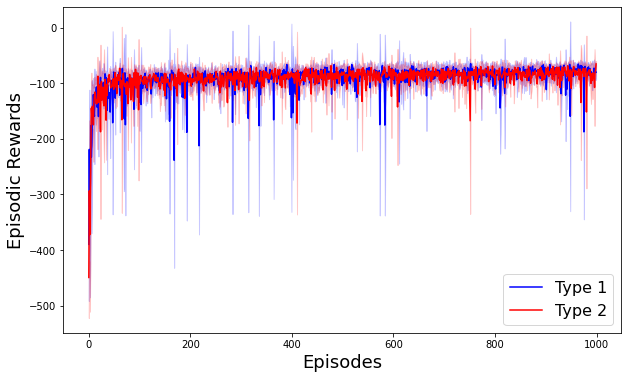

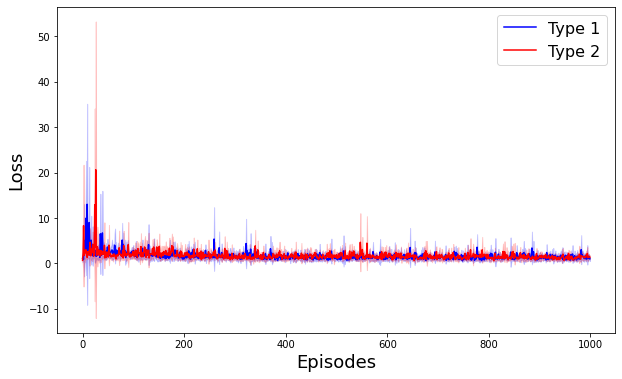

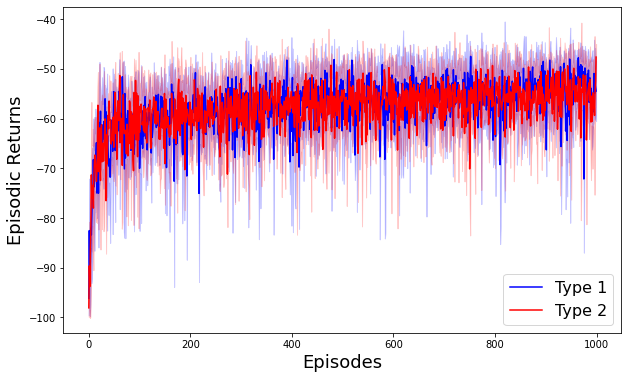

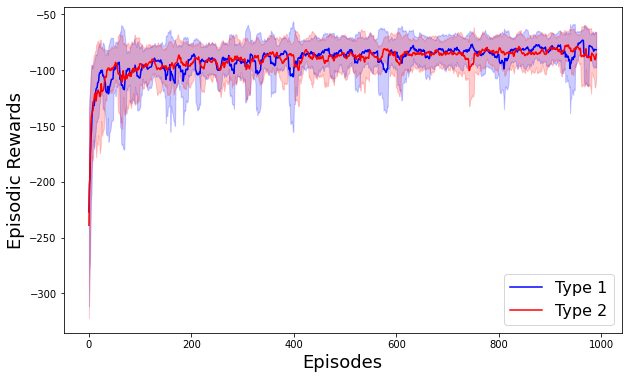

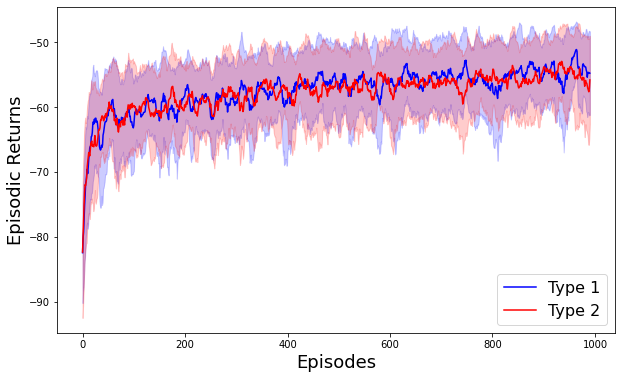

In [22]:
# Dueling DQN
# Acrobot-v1 using Type-1 update
env_name = "Acrobot-v1"
agent_type = "dueling_dqn"
trainer = Trainer(env_name, agent_type, update_type=1, args=args)
rewards1, losses1, returns1 = trainer.train()

# Acrobot-v1 using Type-2 update
env_name = "Acrobot-v1"
agent_type = "dueling_dqn"
trainer = Trainer(env_name, agent_type, update_type=2, args=args)
rewards2, losses2, returns2 = trainer.train()

# Load results
rewards1, losses1, returns1 = results_loader("Acrobot-v1", "dueling_dqn", update_type=1)
rewards2, losses2, returns2 = results_loader("Acrobot-v1", "dueling_dqn", update_type=2)

# Plots
plot = Plot(rewards1, rewards2, losses1, losses2, returns1, returns2, "plots/dueling_dqn_acrobot")

In [23]:
# Hyperparameter tuning for CartPole-v1 using Dueling DQN
args = Args()

'''uncomment for tuning'''
# args_ddqn_cartpole = dueling_dqn_cartpole_hyperparameter_tuning()
# print("Tuned Hyperparameters Dueling DQN CartPole: ", args_ddqn_cartpole.__dict__)
# args = args_ddqn_cartpole

# After tuning, we got the following results:
args.batch_size = 1024
args.buffer_size = int(1e4)
args.target_update_freq = 20

dueling_dqn_cartpole_results = pd.read_csv('hptuning/dueling_dqn_cartpole.csv')
dueling_dqn_cartpole_results = dueling_dqn_cartpole_results.sort_values(by='Average Rewards Mean', ascending=False)
print("Dueling DQN CartPole Hyperparameter Tuning Results")
dueling_dqn_cartpole_results


Dueling DQN CartPole Hyperparameter Tuning Results


,Batch Size,Buffer Size,Target Update Freq,Average Rewards Mean
4,128,10000,20,335.6390
6,128,1000,20,323.8020
0,32,10000,20,322.5494
5,128,10000,50,322.4030
2,32,1000,20,305.1562
1,32,10000,50,302.2162
3,32,1000,50,295.2856
7,128,1000,50,292.4920
9,1024,10000,50,285.0252
8,1024,10000,20,283.0640


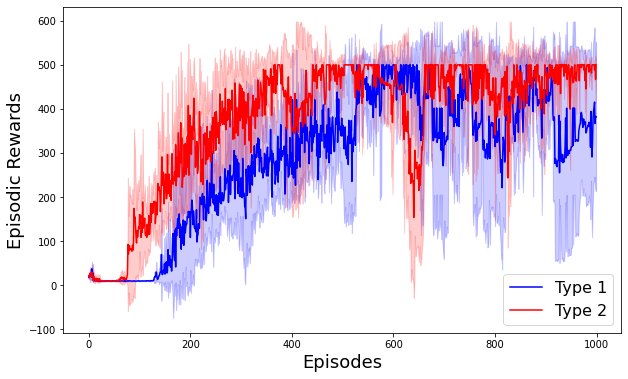

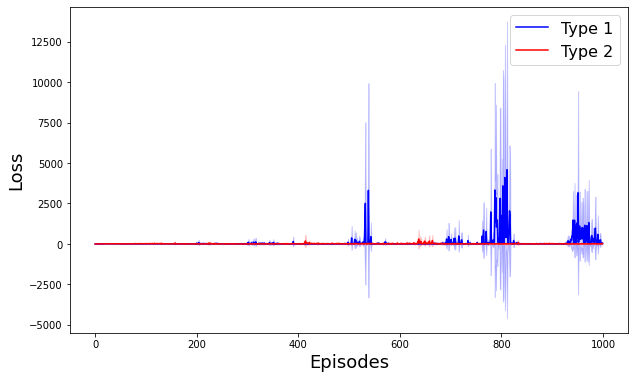

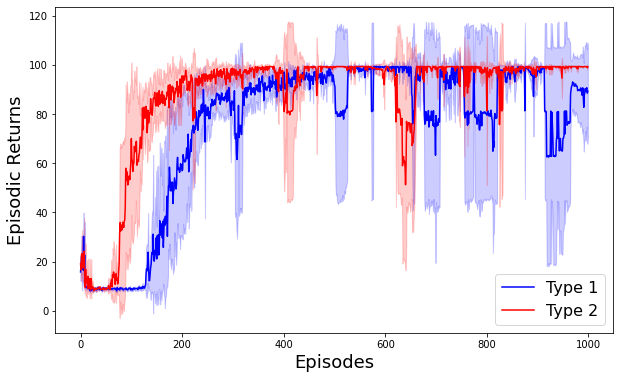

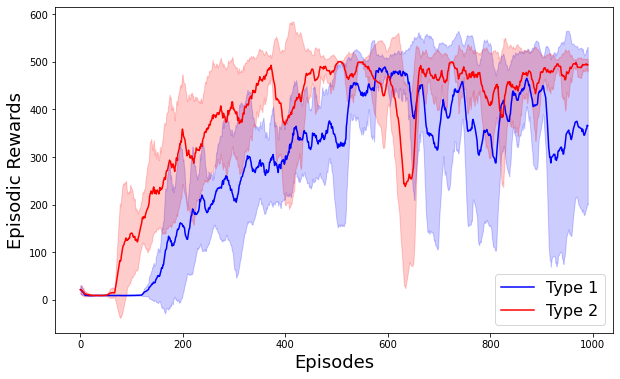

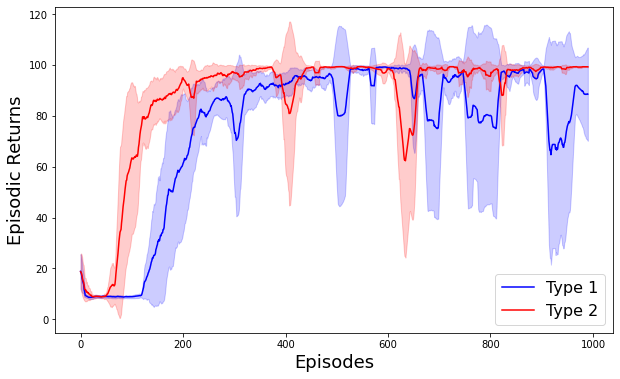

In [24]:
# Dueling DQN
# CartPole-v1 using Type-1 update
env_name = "CartPole-v1"
agent_type = "dueling_dqn"
trainer = Trainer(env_name, agent_type, update_type=1, args=args, save_results=False)
rewards1, losses1, returns1 = trainer.train()

# CartPole-v1 using Type-2 update
env_name = "CartPole-v1"
agent_type = "dueling_dqn"
trainer = Trainer(env_name, agent_type, update_type=2, args=args)
rewards2, losses2, returns2 = trainer.train()

# Load results
rewards1, losses1, returns1 = results_loader("CartPole-v1", "dueling_dqn", update_type=1)
rewards2, losses2, returns2 = results_loader("CartPole-v1", "dueling_dqn", update_type=2)

# Plots
plot = Plot(rewards1, rewards2, losses1, losses2, returns1, returns2, "plots/dueling_dqn_cartpole")

### Monte-Carlo REINFORCE

In [35]:
# Hyperparameter tuning for Acrobot-v1 using REINFORCE
args = Args()

'''uncomment for tuning'''
# args_reinforce_acrobot = mc_reinforce_acrobot_hyperparameter_tuning()
# print("Tuned Hyperparameters REINFORCE Acrobot: ", args_reinforce_acrobot.__dict__)
# args = args_reinforce_acrobot

# After tuning, we got the following results:
args.h1_dim = 128
args.h2_dim = 128*4

mc_reinforce_acrobot_results = pd.read_csv('hptuning/mc_reinforce_acrobot.csv')
mc_reinforce_acrobot_results = mc_reinforce_acrobot_results.sort_values(by='Average Rewards Mean', ascending=False)
print("REINFORCE Acrobot Hyperparameter Tuning Results")
mc_reinforce_acrobot_results

REINFORCE Acrobot Hyperparameter Tuning Results


,h1_dim,h2_dim,Average Rewards Mean
0,128,64,-165.4448
2,256,64,-261.7226
1,128,128,-264.9214
3,256,128,-417.1384


In [34]:
rewards1, losses1, returns1 = results_loader("Acrobot-v1", "reinforce", baseline=False)
# rewards2, losses2, returns2 = results_loader("Acrobot-v1", "reinforce", baseline=True)

# avg of mean of rewards1
np.mean(rewards1.mean(axis=0))

-428.232

In [36]:
# Monte Carlo REINFORCE
# Acrobot-v1 without baseline
env_name = "Acrobot-v1"
agent_type = "reinforce"
trainer = Trainer(env_name, agent_type, baseline=False, args=args)
rewards1, losses1, returns1 = trainer.train()

# Acrobot-v1 with baseline
env_name = "Acrobot-v1"
agent_type = "reinforce"
trainer = Trainer(env_name, agent_type, baseline=True, args=args)
rewards2, losses2, returns2 = trainer.train()

# Load results
rewards1, losses1, returns1 = results_loader("Acrobot-v1", "reinforce", baseline=False)
rewards2, losses2, returns2 = results_loader("Acrobot-v1", "reinforce", baseline=True)

# Plots
plot = Plot(rewards1, rewards2, losses1, losses2, returns1, returns2, "plots/mc_reinforce_acrobot")

  0%|          | 0/5 [00:00<?, ?it/s]

Episode: 0, Reward: -270.0


  0%|          | 0/5 [00:22<?, ?it/s]


KeyboardInterrupt: 

In [28]:
# Hyperparameter tuning for CartPole-v1 using REINFORCE
args = Args()

'''uncomment for tuning'''
# args_reinforce_cartpole = mc_reinforce_cartpole_hyperparameter_tuning()
# print("Tuned Hyperparameters REINFORCE CartPole: ", args_reinforce_cartpole.__dict__)
# args = args_reinforce_cartpole

# After tuning, we got the following results:
args.h1_dim = 128
args.h2_dim = 128*4

mc_reinforce_cartpole_results = pd.read_csv('hptuning/mc_reinforce_cartpole.csv')
mc_reinforce_cartpole_results = mc_reinforce_cartpole_results.sort_values(by='Average Rewards Mean', ascending=False)
print("REINFORCE CartPole Hyperparameter Tuning Results")
mc_reinforce_cartpole_results

REINFORCE CartPole Hyperparameter Tuning Results


,h1_dim,h2_dim,Average Rewards Mean
1,128,128,276.6860
0,128,64,258.8150
3,256,128,209.5964
2,256,64,209.4506


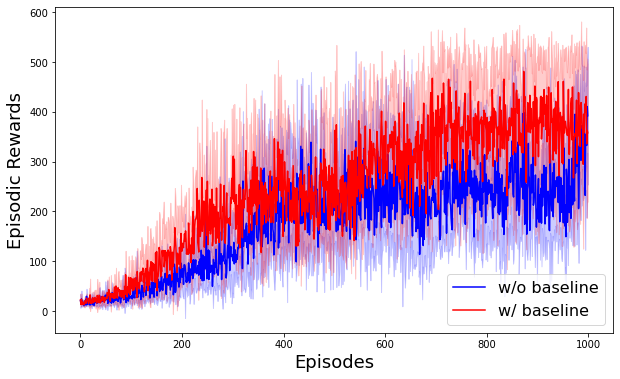

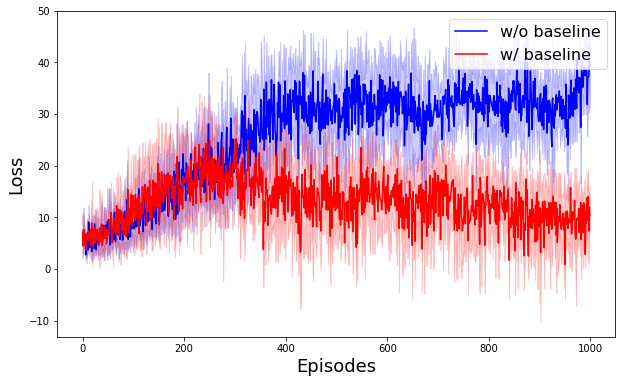

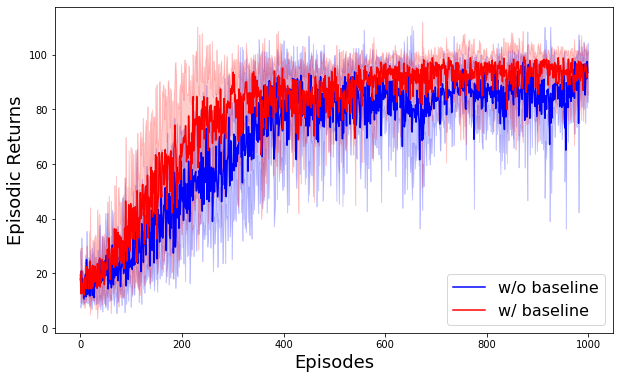

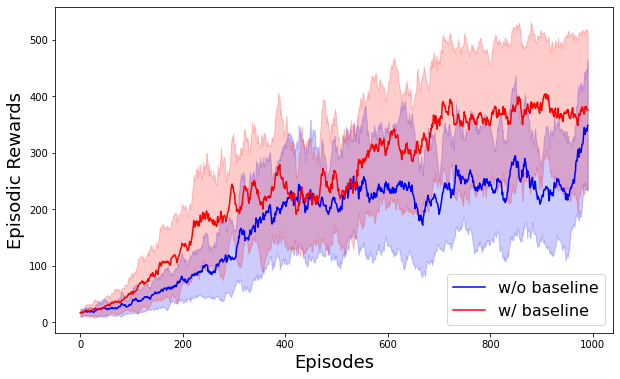

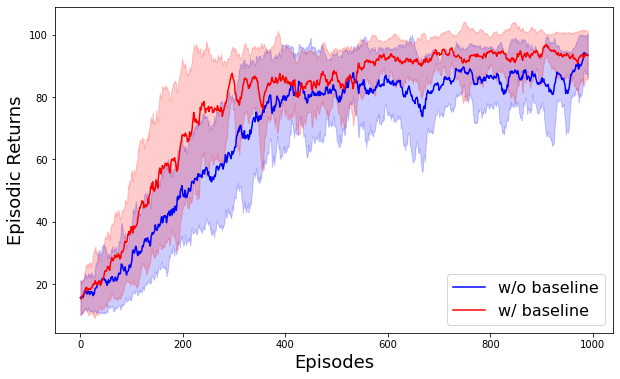

In [30]:
# Monte Carlo REINFORCE
# CartPole-v1 without baseline
env_name = "CartPole-v1"
agent_type = "reinforce"
trainer = Trainer(env_name, agent_type, baseline=False, args=args)
rewards1, losses1, returns1 = trainer.train()

# CartPole-v1 with baseline
env_name = "CartPole-v1"
agent_type = "reinforce"
trainer = Trainer(env_name, agent_type, baseline=True, args=args)
rewards2, losses2, returns2 = trainer.train()

# Load results
rewards1, losses1, returns1 = results_loader("CartPole-v1", "reinforce", baseline=False)
rewards2, losses2, returns2 = results_loader("CartPole-v1", "reinforce", baseline=True)

# Plots
plot = Plot(rewards1, rewards2, losses1, losses2, returns1, returns2, "plots/mc_reinforce_cartpole")